In [2]:
%cd ..
%pwd

/home/guilherme/scantensus-sdy


/home/guilherme/ai-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/guilherme/scantensus-sdy'

In [13]:
from src import SDYFile

import torch
import torchvision
import torchvision.transforms as T
import numpy as np

from scipy.signal import resample_poly

import matplotlib.pyplot as plt
import PIL

import ipywidgets as widgets
from IPython import display

In [4]:
sdy = SDYFile('sample_data/sample.sdy')

# 1. Spectrum + Flow Rendering

TypeError: unhashable type: 'numpy.ndarray'

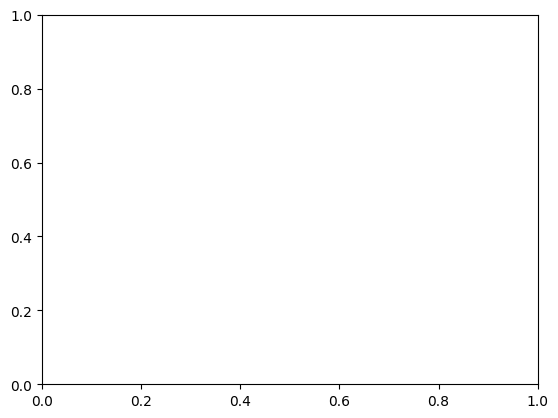

In [54]:
def render_spectrum_with_flow_tracing(sdy: SDYFile, interval: tuple[int, int], invert: bool = True):
    """
    Renders the spectrum with flow tracing in the respecting interval.

    :param sdy: SDYFile object
    :param interval: tuple of start and end index of the interval
    :param invert: invert the output image in the X axis. Defaults to `True`.
    """

    start, end = interval

    spectrum_img = sdy.spectrum[:, start:end]
    spectrum_img = np.sqrt(spectrum_img * 2) * 1.5

    flow = sdy.flow[start:end]

    plt.imshow(spectrum_img, origin='lower')
    plt.plot(flow)


start = 50_000
end = 51_000

render_spectrum_with_flow_tracing(sdy, (start, end), invert=False)

# 2. Curve Sampling

There are three different curves we want to be able to resample and export to end users, these are:
 1. PA curve
 2. PD curve
 3. Flow curve

 

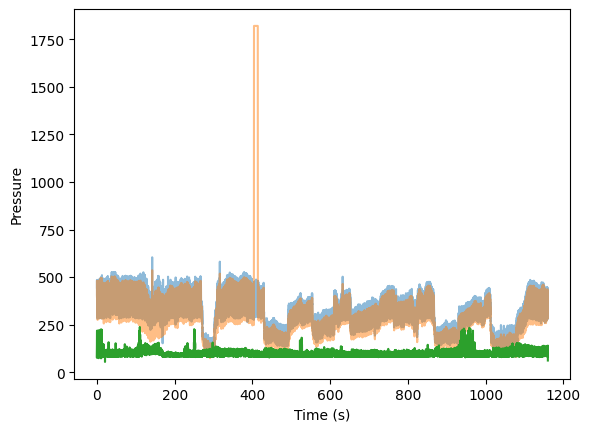

In [48]:
def generate_time_axis(data: np.ndarray, frequency: float) -> np.ndarray:
    """
    Generates the time axis for a given data array and frequency.

    :param data: data array
    :param frequency: frequency of the data
    :return: time axis
    """

    return np.arange(data.shape[0]) / frequency

def resample(data: np.ndarray, original_frequency: float, target_frequency: float = 50) -> np.ndarray:
    """
    Resamples the data to the target frequency.

    :param data: data to resample
    :param original_frequency: original frequency of the data
    :param target_frequency: target frequency of the data
    :return: resampled data
    """
    # Calculate resampling ratio
    if original_frequency < target_frequency:
        # Upsampling
        up = target_frequency
        down = original_frequency
    else:
        # Downsampling
        up = original_frequency
        down = target_frequency

    # Resample data
    resampled_data = resample_poly(data, up, down)

    # Create time array
    time = np.arange(resampled_data.shape[0]) / target_frequency

    return resampled_data, time

time = generate_time_axis(sdy.pa, frequency=200)

downsampled_flow = resample(sdy.flow, original_frequency=400, target_frequency=200)[0]

plt.plot(time, sdy.pa, alpha=0.5)
plt.plot(time, sdy.pd, alpha=0.5)
plt.plot(time, downsampled_flow)

plt.xlabel('Time (s)')
plt.ylabel('Pressure')

plt.show()

In [50]:
len(sdy.pa) / len(sdy.flow)

2.0

# 3. AI Data Preparation

In [6]:
# do a bunch of transformations

def apply_pretransforms(input: np.ndarray):
    pixel_array = input
    pixel_array = torch.from_numpy(pixel_array.astype("float32"))

    pixel_array = torch.sqrt(pixel_array * 2) * 1.5
    pixel_array = torch.clip(pixel_array, 0, 255)
    pixel_array = torch.flip(pixel_array, [0])
    pixel_array = pixel_array.squeeze(0).squeeze(0).repeat([1,3,1,1])

    return pixel_array

from src.sdy_processor import SDYProcessor

def preprocess_data(x: np.ndarray, is_spectrum: bool = False) -> list[torch.Tensor]:
    final_data = []

    #t = apply_pretransforms(x)
    t = torch.from_numpy(x.astype("float32"))
    source_list, destination_list = SDYProcessor()._get_shards(1024, 256, t.shape[-1])

    for i, (source, destination) in enumerate(zip(source_list, destination_list)):
        source_start, source_end = source
        destination_start, destination_end = destination

        if is_spectrum:
            flow_t = t[..., source_start:source_end]
            flow_t = flow_t.to(device='cpu', dtype=torch.float32, non_blocking=True).div(255.0).add(-0.5)
        else:
            flow_t = t[..., source_start:source_end]
            flow_t = flow_t.to(device='cpu', dtype=torch.float32, non_blocking=True)

        final_data.append(flow_t)

    return final_data

spectrum_images = preprocess_data(sdy.spectrum, is_spectrum=True)
flow_tracing = preprocess_data(sdy.flow)
baseline_tracing = preprocess_data(sdy.flow_baseline)
scale_tracing = preprocess_data(sdy.flow_scale)

print(f'Processed spectrum and flow into {len(spectrum_images)} shards.')

Processed spectrum and flow into 226 shards.


In [7]:
def show_spectrum(idx: int):
    return T.ToPILImage()(spectrum_images[idx].add(0.5).squeeze())

widgets.interact(show_spectrum, idx=widgets.IntSlider(min=0, max=len(spectrum_images)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='idx', max=225), Output()), _dom_classes=('widget-interac…

<function __main__.show_spectrum(idx: int)>

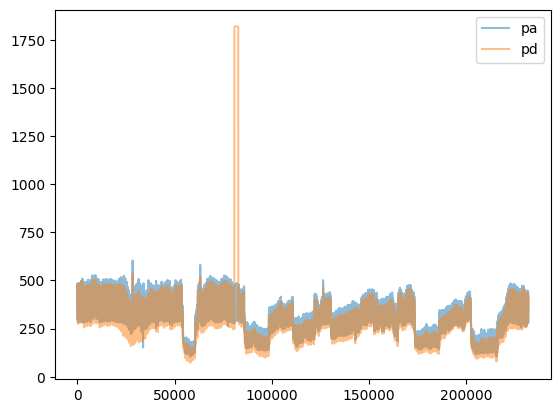

In [6]:
plt.plot(np.arange(len(sdy.pa)), sdy.pa, alpha=0.5, label='pa')
plt.plot(np.arange(len(sdy.pd)), sdy.pd, alpha=0.5, label='pd')

# frequency: 200hz (or 50hz)
plt.legend()

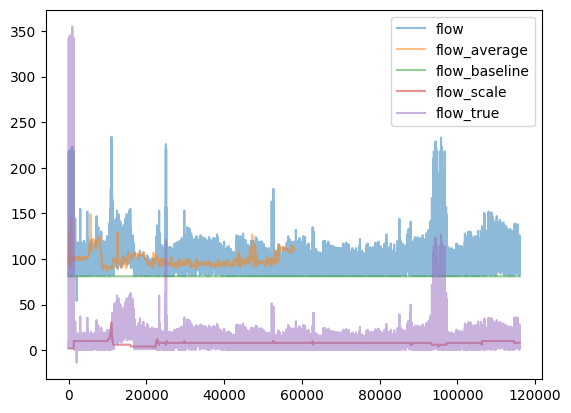

In [7]:
plt.plot(np.arange(len(sdy.flow)), sdy.flow, alpha=0.5, label='flow')
plt.plot(np.arange(len(sdy.flow_average)), sdy.flow_average, alpha=0.5, label='flow_average')
plt.plot(np.arange(len(sdy.flow_baseline)), sdy.flow_baseline, alpha=0.5, label='flow_baseline')
plt.plot(np.arange(len(sdy.flow_scale)), sdy.flow_scale, alpha=0.5, label='flow_scale')
plt.plot(np.arange(len(sdy.flow_true)), sdy.flow_true, alpha=0.5, label='flow_true')
plt.legend()

torch.Size([1, 3, 256, 1024])


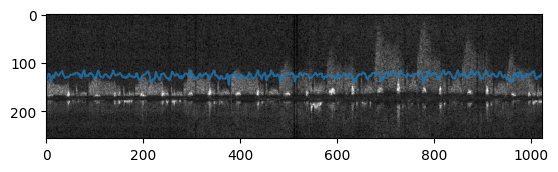

In [8]:
IDX = 20

print(spectrum_images[IDX].shape)

trace = (flow_tracing[IDX][0, 0, 0, :] * scale_tracing[IDX][0,0,0:].squeeze())

plt.imshow(T.ToPILImage()(spectrum_images[IDX].add(0.5).squeeze()))
plt.plot(np.arange(flow_tracing[IDX].shape[-1]), trace, alpha=0.8)

In [62]:
flow_tracing[IDX][0, 0, 0, :] - baseline_tracing[IDX][0, 0, 0, :] + 256

tensor([258.8512, 259.0554, 258.5414,  ..., 257.8007, 257.4751, 257.2551])

In [13]:
from src.minio import MinioConfig
from dotenv import load_dotenv

load_dotenv()
minio_config = MinioConfig.from_env()

MODEL_CHECKPOINT = "matt-output/checkpoints/flow/flow-004/weights-400.pt"


In [14]:
res = minio_config.build_client().get_object(minio_config.bucket, MODEL_CHECKPOINT)

In [12]:
from src.nets.HRNetV2M7 import HighResolutionNet

In [ ]:
model = HighResolutionNet(cfg={}) # i need to find this cfg